## Relatório Projeto 1 - Multi-core - Supercomp 2019.2
### Frederico Vilela Curti
___

### Descrição do problema tratado

- O problema tratado nesse projeto é o problema do Caixeiro Viajante, no qual, de forma lúdica, um vendedor possui uma lista de empresas que ele deverá visitar ao longo do dia, e não existe uma ordem para tal. Desde que todas as empresas sejam visitadas, o objetivo do dia está cumprido. Para otimizar esse percurso e passar o maior tempo possível com seus clientes, ele precisa encontrar uma rota que resulta no menor caminho percorrido ao final do dia. Nesse problema, aas empresas serão representadas por pontos em um plano

### Organização em alto nível do projeto.

- O projeto foi escrito em C++ e é monolítico, possuindo uma `struct` auxiliar `point` para criar um vetor análogo às duas listas `x` e `y` do código original fornecido em python. Diferente dos projetos anteriores, onde existiam múltiplos arquivos de código fonte, nesse as variações foram feitas usando macros, que determinam em tempo de compilação dos executáveis se eles rodarão a versão paralela inocente, sequencial ou a paralela com otimização branch and bound. Além disso somente a otimização -O3 de compilação será testada. Por fim, existe um script `gerador.py` capaz de gerar as entradas que serão consumidas por ambas as versões em `python` e `c++`. Essas entradas representam um conjunto de *N* pontos e seguem o seguinte formato:

```
N
x_0 y_0
x_1 y_1
....
x_(N-1) y_(N-1)
```

Onde:

* `N` é o número de pontos do problema.
- Cada linha subsequente contém um ponto com as seguintes propriedades:
    * coordenada no eixo x `x_N`
    * coordenada no eixo y `y_N`

Quando lidos, as coordenadas de cada ponto são armazenados em um `struct point` e armazenadas em um `std::vector<point>`.

A solução do problema, contida no método `main` do arquivo [`tsp.cpp`](tsp.cpp), aloca diversos vetores auxiliares que serão compartilhados entre as chamadas recursivas (e entre as tasks, nas versões paralelas).

A paralelização foi implementada com auxílio da biblioteca `OpenMP`, que fornece blocos estruturados e diretrizes de compilação (`#pragma omp`) com ferramentas para a execução paralela de código distribuído no número de threads determinado pela variável de ambiente `OMP_NUM_THREADS`.

Por se tratar de um código recursivo, a maneira apropriada de utilizar o `OpenMP` é através dos constructs [`tasks`](https://www.openmp.org/spec-html/5.0/openmpse18.html#x69-1990002.10), que permitem com que todas as threads, incluindo a main (0), executem chamadas de função em paralelo e ainda é possível aguardar com que todas as threads tenham concluído seu bloco com a diretriz `#pragma omp taskwait`. Como a invocação dessas tasks possui um overhead alto, esse método não é performante para todos os passos da recursão pois os passos finais serão muitos e tratarão de uma versão reduzida do problema. Para contornar esse problema o que foi feito é que o primeiro andar da árvore de recursão foi paralelizado, e a partir destes nós a execução dos filhos será sequencial.

O tempo de cada execução é mensurado com a biblioteca `chrono`, usando o `high_resolution_clock`, que ao término da simulação é impresso na saída de erros *(stderr)*, para ser capturado pelo código de benchmark.

O formato de saída será:
```
dist opt
0 e_1 ... e_(N-1)
```

Onde:

- `dist` é o comprimento do caminho encontrado usando 5 casas decimais.
- `e_1 ... e_(N-1)` é a sequência de empresas visitadas no trajeto
- `opt` é `1` se a solução encontrada é a ótima e `0` se foi usada outra estratégia

___
## Validação do código

Conforme mencionado na seção **Organização em alto nível do projeto**, foi fornecido um [script em `python`](tsp.py) capaz de resolver o problema, porém com um desempenho subpar, especialmente notável para entradas com um número maior de pontos. Só o fato da conversão desse código sequencial inocente para *C++* já deve trazer um ganho significativo de performance, e como o que nos interessa é medir os ganhos de desempenho dos diversos executáveis, é fundamental também que ele produza o resultado correto. Para tal, abaixo vamos comparar a saída do código em *C++* com a saída do código em *python* dada uma mesma entrada.

In [36]:
# Importando dependências
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
result_cpp_seq = subprocess.run(["build/tsp-O3-seq"], stdin=open(f"input/in10.txt"), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
result_cpp_par = subprocess.run(["build/tsp-O3-parallel"], stdin=open(f"input/in10.txt"), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
result_cpp_bb = subprocess.run(["build/tsp-O3-bb"], stdin=open(f"input/in10.txt"), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
result_python = subprocess.run(["python3", "tsp.py"], stdin=open(f"input/in10.txt"), stdout=subprocess.PIPE, stderr=subprocess.PIPE)


Abaixo estão listados o caminho resultante de cada execução, no qual a segunda linha indica a ordem na qual os pontos devem ser percorridos.

**Saída do programa em C++ - sequencial**

In [23]:
print(result_cpp_seq.stdout.decode())

7050.70882 1
0 6 7 1 3 5 8 9 4 2 



**Saída do programa em C++ - paralelo**

In [26]:
print(result_cpp_par.stdout.decode())

7050.70882 1
0 6 7 1 3 5 8 9 4 2 



**Saída do programa em C++ - branch and bound**

In [28]:
print(result_cpp_bb.stdout.decode())

7050.70882 1
0 6 7 1 3 5 8 9 4 2 



**Saída do programa em Python**

In [29]:
print(result_python.stdout.decode())

7050.7088162092 1
0 6 7 1 3 5 8 9 4 2



Como observado, tanto o caminho quanto a distância resultante de todas as versões foi o mesmo (dada uma diferença de arredondamento) para uma mesma entrada gerada aleatoriamente com 10 pontos, logo assumiremos que o código produz um resultado computacionalmente correto. Na seção seguinte será avaliado o desemepenho de todas as variantes geradas.

___
## Benchmark
Com a algoritmo validada, agora é hora de testar simulações maiores e verificar se houveram ganhos de desempenho com as flags de compilação, com a paralelização usando o `OpenMP` de maneira inocente e sua otimização `Branch and Bound`. Nessa seção, não iremos mais validar a saída, apenas comparar o tempo de execução entre as diferentes versões. Foram criadas 3 versões, todas usando a flag -O3 para as seguintes versões do algoritmo:

- Sequencial
- Paralelo
- Paralelo com Branch and Bound (BB)

O sistema no qual esse benchmark foi executado possui as seguintes configurações:
***
- CPU: Intel Core i7 4780HQ @ 2.5Ghz
- GPU: AMD Radeon R9 M370X 2 GB
- RAM: 16 GB 1600 MHz DDR3
- SO: macOS Mojave 10.14.6
***
Os testes foram executados com o notebook plugado na tomada para evitar diminuições do clock para poupar a bateria. Serão executados TESTS_PER_EXECUTABLE testes (default 1 - gostaria que fossem mais, mas sem tempo ;( ) para uma média - esse número poderia ser maior mas infelizmente algumas execuções podem demorar muito, logo precisaria de mais tempo para tal.

In [65]:
TESTS_PER_EXECUTABLE = 1
INPUTS = ['in5.txt', 'in10.txt', 'in12.txt', 'in13.txt']
EXECUTABLES = [x for x in os.listdir('build') if "tsp" in x]
df = pd.DataFrame()

for exe in EXECUTABLES:
    for input_file in INPUTS:
        for i in range(TESTS_PER_EXECUTABLE):
            print('working:', exe, input_file, i)
            result = subprocess.run([f"build/{exe}"], stdin=open(f'./input/{input_file}'), stderr=subprocess.PIPE)
            df = df.append({
                'version': exe.replace('tsp-', ''),
                'N': input_file.replace('in', '').replace('.txt', ''),
                'duration': float(result.stderr.decode().split()[0].replace('+', ''))/1e3,
            }, ignore_index=True)


working: tsp-O3-bb in5.txt 0
working: tsp-O3-bb in10.txt 0
working: tsp-O3-bb in12.txt 0
working: tsp-O3-bb in13.txt 0
working: tsp-O3-seq in5.txt 0
working: tsp-O3-seq in10.txt 0
working: tsp-O3-seq in12.txt 0
working: tsp-O3-seq in13.txt 0
working: tsp-O3-parallel in5.txt 0
working: tsp-O3-parallel in10.txt 0
working: tsp-O3-parallel in12.txt 0
working: tsp-O3-parallel in13.txt 0


In [67]:
df

,N,duration,version
0,5,0.344,O3-bb
1,10,5.298,O3-bb
2,12,49.179,O3-bb
3,13,334.169,O3-bb
4,5,0.007,O3-seq
5,10,23.043,O3-seq
6,12,2849.180,O3-seq
7,13,35180.700,O3-seq
8,5,0.292,O3-parallel
9,10,24.920,O3-parallel


#### Gráfico 1 - **Crescimento do tempo**

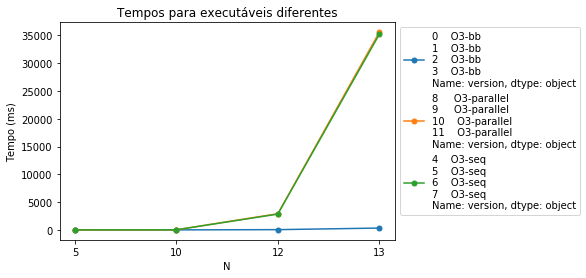

In [169]:
durations = df.groupby('version')
fig, ax = plt.subplots()
for name, group in durations:
    ax.plot(group.N, group.duration, marker='o', linestyle='-', ms=5, label=group.version)

plt.title('Tempos para executáveis diferentes')
plt.ylabel('Tempo (ms)')
plt.xlabel('N')
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.show()

#### Gráfico 2 - **Média dos tempos por versão de executável**

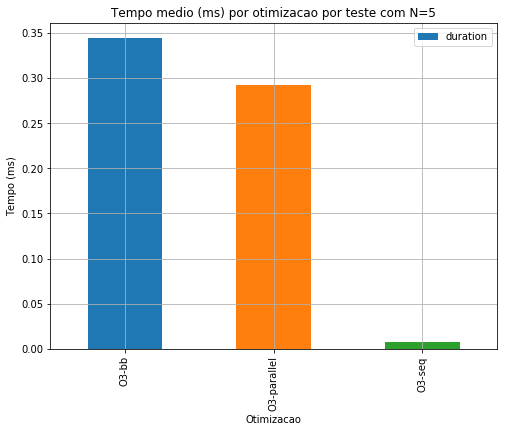

In [146]:
ax = df[(df.N == '5')].groupby('version').duration.mean().plot(kind='bar',legend=True, figsize=(8,6), title='Tempo medio (ms) por otimizacao por teste com N=5', grid=True)
ax.set(xlabel='Otimizacao' , ylabel='Tempo (ms)')
plt.show()

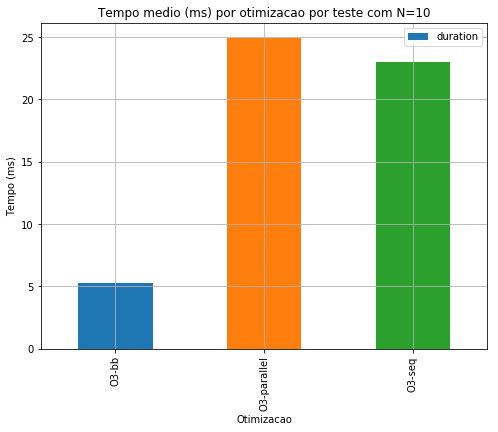

In [145]:
ax = df[(df.N == '10')].groupby('version').duration.mean().plot(kind='bar',legend=True, figsize=(8,6), title='Tempo medio (ms) por otimizacao por teste com N=10', grid=True)
ax.set(xlabel='Otimizacao' , ylabel='Tempo (ms)')
plt.show()

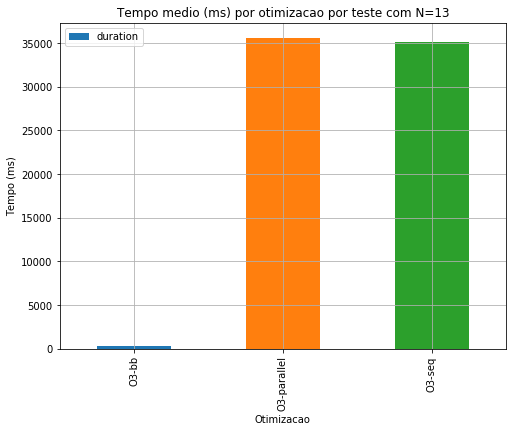

In [170]:
ax = df[(df.N == '13')].groupby('version').duration.mean().plot(kind='bar',legend=True, figsize=(8,6), title='Tempo medio (ms) por otimizacao por teste com N=13', grid=True)
ax.set(xlabel='Otimizacao' , ylabel='Tempo (ms)')
plt.show()

#### Gráfico 3 - **Seq vs Parallel** (mean)

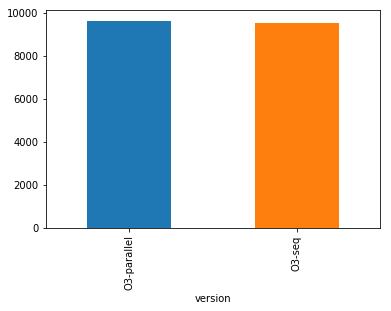

In [95]:
df[(df.version == 'O3-parallel') | (df.version == 'O3-seq')].groupby('version').duration.mean().plot.bar()

In [172]:
df.groupby('version').duration.describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
O3-bb,4.0,97.2475,159.465123,0.344,4.0595,27.2385,120.4265,334.169
O3-parallel,4.0,9626.7380,17347.728697,0.292,18.7630,1469.6800,11077.6550,35567.300
O3-seq,4.0,9513.2325,17163.853877,0.007,17.2840,1436.1115,10932.0600,35180.700


___
## Conclusão

Infelizmente, não foi possível encontrar uma melhora significativa com a paralelização inocente, com resultados incrivelmente similares à versão sequencial, no entandom com a otimização Branch and Bound, encontramos uma diminuição absurda no tempo, em uma ordem de quase 100 vezes na média para os testes realizados, o que é muito impressionante.
